### 对已有数据进行逻辑回归模型训练（imbalance data 无操作）

#### 读取文件及数据预处理

In [1]:
FILE_NAME = 'result_20190921.xlsx'
SHEET_NAME = 'Sheet1'
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 导入SMOTE算法，使用SOMTE对数据进行生成
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
import os
path = 'data' + os.sep + FILE_NAME
pdData = pd.read_excel(path, sheet_name=SHEET_NAME)
pdData.head()

,URL,Xpath,Completeness,ActualCompleteness,Purity,CompletenessGain,NumberOfRooms,RoomClass,RoomType,RoomSize,BedType,Wheelchair,Smoking,View,ExtraAttributes,Score,Admitted
0,https://www.oyorooms.com/id/40374-oyo-rooms-oy...,/html,5.0,0.83,0.0,0.0,0.1,Standard,Double Room,187 sqft,Double,0.0,unknown,View,"ac,tv,wifi",0.93,0.0
1,https://www.oyorooms.com/id/40374-oyo-rooms-oy...,/html/body,5.0,0.83,0.0,0.0,0.1,Standard,Double Room,187 sqft,Double,0.0,unknown,View,"ac,tv,wifi",0.93,0.0
2,https://www.oyorooms.com/id/40374-oyo-rooms-oy...,/html/body/div[2],5.0,0.83,0.0,0.0,0.1,Standard,Double Room,187 sqft,Double,0.0,unknown,View,"ac,tv,wifi",0.93,0.0
3,https://www.oyorooms.com/id/40374-oyo-rooms-oy...,/html/body/div[2]/div,5.0,0.83,0.0,0.0,0.1,Standard,Double Room,187 sqft,Double,0.0,unknown,View,"ac,tv,wifi",0.93,0.0
4,https://www.oyorooms.com/id/40374-oyo-rooms-oy...,/html/body/div[2]/div/div[3],5.0,0.83,0.0,0.0,0.1,Standard,Double Room,187 sqft,Double,0.0,unknown,View,"ac,tv,wifi",0.93,0.0


In [3]:
pdData.shape

(10726, 17)

In [4]:
# 数据预处理
pdData = pdData.dropna(axis = 0,how='any')
pdData = pdData.drop(['URL', 'Xpath', 'Completeness', 'RoomClass', 'RoomType', 'RoomSize', 'BedType', 'Wheelchair', 'Smoking', 'View', 'ExtraAttributes', 'Score'], axis=1)
pdData.shape

(10710, 5)

In [5]:
pdData.head(5)

,ActualCompleteness,Purity,CompletenessGain,NumberOfRooms,Admitted
0,0.83,0.0,0.0,0.1,0.0
1,0.83,0.0,0.0,0.1,0.0
2,0.83,0.0,0.0,0.1,0.0
3,0.83,0.0,0.0,0.1,0.0
4,0.83,0.0,0.0,0.1,0.0


#### 打印数据分布

Text(0, 0.5, 'Frequency')

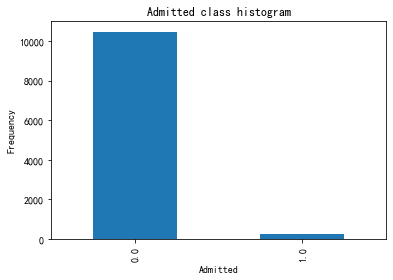

In [6]:
count_classes = pd.value_counts(pdData['Admitted'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Admitted class histogram")
plt.xlabel("Admitted")
plt.ylabel("Frequency")

#### 对数据进行切分，划分为训练集和测试集

In [7]:
# 将数据划分为特征和特征值
columns=pdData.columns
# The labels are in the last column ('Class'). Simply remove it to obtain features columns
features_columns=columns.delete(len(columns)-1)

features=pdData[features_columns]
labels=pdData['Admitted']

# 对数据进行切分
features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels, 
                                                                            test_size=0.25, 
                                                                            random_state=0)

#### 对训练集进行KFold切分，然后进行交叉验证，基于racall均值获得最优惩罚力度

In [8]:
#Recall = TP/(TP+FN)
from sklearn.linear_model import LogisticRegression
# cross_val_score 交叉验证评估结果
# KFold 用于做训练集的切分，可以切分成任意份数
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,recall_score,classification_report

In [9]:
def printing_Kfold_scores(x_train_data,y_train_data):
    # 使用 KFold 将数据切分成5部分
    # n_splits：表示划分几等份
    # shuffle：在每次划分时，是否进行洗牌
    
    fold = KFold(n_splits=5, shuffle=False)
#     get_n_splits(X=None, y=None, groups=None) 获取参数n_splits的值
#     fold.get_n_splits(list)
#     fold = KFold(len(y_train_data),n_splits=5,shuffle=False) 
    
    # Different C parameters
    c_param_range = [0.01,0.1,1,10,100]

    results_table = pd.DataFrame(index = range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range

    # the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]
    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        # split(X, y=None, groups=None)：将数据集划分成训练集和测试集，返回索引生成器
        for iteration, indices in enumerate(fold.split(x_train_data),start=1):

            # 实例化逻辑回归对象，使用L1进行惩罚 惩罚力度分别为 [0.01,0.1,1,10,100]
            lr = LogisticRegression(C = c_param, penalty = 'l1')

            # fit 训练
            lr.fit(x_train_data.iloc[indices[0],:],y_train_data.iloc[indices[0],:].values.ravel())

            # 预测验证数据
            y_pred_undersample = lr.predict(x_train_data.iloc[indices[1],:].values)

            # 计算召回率
            recall_acc = recall_score(y_train_data.iloc[indices[1],:].values,y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration ', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of.
        results_table.loc[j,'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')
    
    print(results_table)
    results_table['Mean recall score']=results_table['Mean recall score'].astype('float64')
    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    
    # Finally, we can check which C parameter is the best amongst the chosen.
    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter = ', best_c)
    print('*********************************************************************************')
    
    return best_c

In [12]:
features_train_df = pd.DataFrame(features_train)
labels_train_df = pd.DataFrame(labels_train)
best_c = printing_Kfold_scores(features_train_df,labels_train_df)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  1 : recall score =  0.0
Iteration  2 : recall score =  0.0
Iteration  3 : recall score =  0.0
Iteration  4 : recall score =  0.0
Iteration  5 : recall score =  0.0

Mean recall score  0.0

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  1 : recall score =  0.0
Iteration  2 : recall score =  0.0
Iteration  3 : recall score =  0.0
Iteration  4 : recall score =  0.0
Iteration  5 : recall score =  0.0

Mean recall score  0.0

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  1 : recall score =  0.0


/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/py

Iteration  2 : recall score =  0.0
Iteration  3 : recall score =  0.02564102564102564
Iteration  4 : recall score =  0.0
Iteration  5 : recall score =  0.0

Mean recall score  0.005128205128205128

-------------------------------------------
C parameter:  10
-------------------------------------------

Iteration  1 : recall score =  0.0


/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/py

Iteration  2 : recall score =  0.0
Iteration  3 : recall score =  0.05128205128205128
Iteration  4 : recall score =  0.0
Iteration  5 : recall score =  0.0

Mean recall score  0.010256410256410256

-------------------------------------------
C parameter:  100
-------------------------------------------

Iteration  1 : recall score =  0.0


/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/py

Iteration  2 : recall score =  0.0
Iteration  3 : recall score =  0.05128205128205128
Iteration  4 : recall score =  0.0
Iteration  5 : recall score =  0.0

Mean recall score  0.010256410256410256

   C_parameter Mean recall score
0         0.01                 0
1         0.10                 0
2         1.00        0.00512821
3        10.00         0.0102564
4       100.00         0.0102564
*********************************************************************************
Best model to choose from cross validation is with C parameter =  10.0
*********************************************************************************


/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### 计算recall值及打印混淆矩阵中间方法

In [13]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
def calculate_recall_and_plot_confusion_matrix(best_c, fit_features, fit_labels, predict_features, actual_labels):
    lr = LogisticRegression(C = best_c, penalty = 'l1')
    lr.fit(fit_features,fit_labels.values.ravel())
    y_pred = lr.predict(predict_features.values)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(actual_labels,y_pred)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plt.figure()
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Confusion matrix')
    plt.show()

#### 对自身数据进行预测

/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Recall metric in the testing dataset:  0.0106951871657754


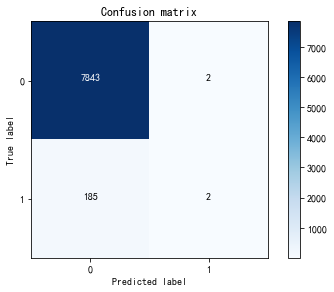

In [17]:
features_train_df = pd.DataFrame(features_train)
labels_train_df = pd.DataFrame(labels_train)
calculate_recall_and_plot_confusion_matrix(best_c, features_train_df, labels_train_df, features_train_df, labels_train_df)

#### 对全部数据进行预测

/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Recall metric in the testing dataset:  0.008333333333333333


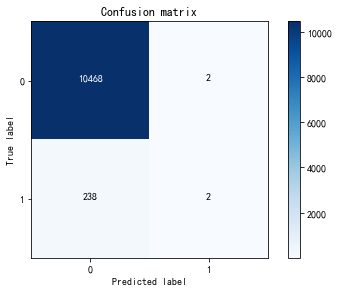

In [19]:
features_train_df = pd.DataFrame(features_train)
labels_train_df = pd.DataFrame(labels_train)
calculate_recall_and_plot_confusion_matrix(best_c, features_train_df, labels_train_df, features, labels)

#### 对测试数据进行预测

/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Recall metric in the testing dataset:  0.0


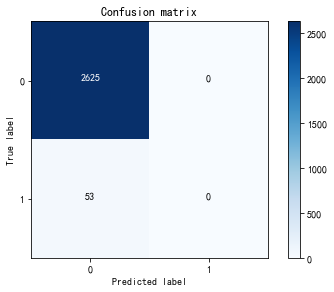

In [18]:
features_train_df = pd.DataFrame(features_train)
labels_train_df = pd.DataFrame(labels_train)
features_test_df = pd.DataFrame(features_test)
labels_test_df = pd.DataFrame(labels_test)
calculate_recall_and_plot_confusion_matrix(best_c, features_train_df, labels_train_df, features_test_df, labels_test_df)

#### 在测试数据集上不同的逻辑回归阈值下racall值的变化

/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Recall metric in the testing dataset:  0.32075471698113206
Recall metric in the testing dataset:  0.09433962264150944
Recall metric in the testing dataset:  0.05660377358490566
Recall metric in the testing dataset:  0.018867924528301886
Recall metric in the testing dataset:  0.0
Recall metric in the testing dataset:  0.0
Recall metric in the testing dataset:  0.0
Recall metric in the testing dataset:  0.0
Recall metric in the testing dataset:  0.0


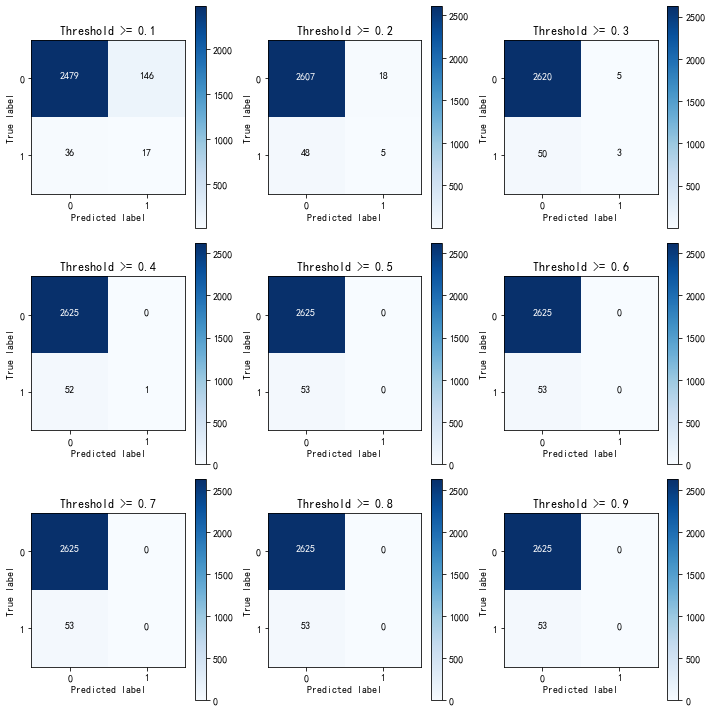

In [20]:
# 基于下采样的不同逻辑回归阈值对结果的影响
features_train_df = pd.DataFrame(features_train)
labels_train_df = pd.DataFrame(labels_train)
features_test_df = pd.DataFrame(features_test)
labels_test_df = pd.DataFrame(labels_test)

lr = LogisticRegression(C = best_c, penalty = 'l1')
lr.fit(features_train_df,labels_train_df.values.ravel())
y_pred_os_proba = lr.predict_proba(features_test_df.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_os_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(labels_test_df,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i) 